In [ ]:
!pip install 'qiskit[visualization]' --quiet
save_and_load = True

     |████████████████████████████████| 6.0MB 13.0MB/s 
     |████████████████████████████████| 18.0MB 126kB/s 
     |████████████████████████████████| 235kB 42.8MB/s 
     |████████████████████████████████| 215kB 55.1MB/s 
     |████████████████████████████████| 2.1MB 34.0MB/s 
     |████████████████████████████████| 163kB 46.3MB/s 
     |████████████████████████████████| 1.5MB 26.2MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 194kB 44.7MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 
     |████████████████████████████████| 614kB 45.7MB/s 
     |████████████████████████████████| 3.2MB 32.2MB/s 
     |████████████████████████████████| 6.3MB 29.5MB/s 


In [ ]:
import random, numpy as np, matplotlib.pyplot as plt, pickle
from scipy.optimize import curve_fit
from google.colab import files
from qiskit import execute
from qiskit import pulse            
from qiskit.pulse import Play
from qiskit.pulse import library as pulse_lib
from qiskit.ignis.characterization.calibrations import rabi_schedules,RabiFitter
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy

from qiskit import IBMQ
API_KEY = 'd1e0708e9ea899bf5a17e43c1b948223b9c9b66e19dfb58a40fc20b0ee383b8595ef447b340a57fa6e3b9da49c9711efbec30a8a68c77ab235e42662cbba1a62'

if save_and_load: # First time run.
  IBMQ.save_account(API_KEY, overwrite=True)
  IBMQ.load_account()
  save_and_load = False

# Channel delays seem to have to be multiples of 16 for >1 qubit backends?
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

specific_choice = False
nqubits = 1
exclude = None

mock_backend = False
if mock_backend:
  from qiskit.providers.aer import PulseSimulator
  from qiskit.test.mock.backends.armonk.fake_armonk import FakeArmonk
  from qiskit.providers.aer.pulse import PulseSystemModel
  armonk_backend = FakeArmonk()
  armonk_model = PulseSystemModel.from_backend(armonk_backend)
  backend = PulseSimulator()
  # Must change functions too. See https://qiskit.org/documentation/tutorials/circuits_advanced/10_pulse_simulator_backend_model.html
elif nqubits is not None and nqubits==1:
  provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
  backend = provider.get_backend('ibmq_armonk')
  print("Selected single qubit backend: ", backend, end="")
elif specific_choice:
  provider=IBMQ.get_provider(hub='ibm-q-minho', group='academicprojects', project='quantalab')
  backend = provider.get_backend('ibmq_guadalupe')
  print("Selected backend: ", backend, end="")
else:
  provider=IBMQ.get_provider(hub='ibm-q-minho', group='academicprojects', project='quantalab')
  conditional_backends = provider.backends(filters=lambda x: 
                            (nqubits is None or x.configuration().n_qubits==nqubits)
                            and not x.configuration().simulator 
                            and x.configuration().backend_name != exclude
                            and x.configuration().open_pulse is True)
  backend = least_busy(conditional_backends,reservation_lookahead=2*60)
  print("Selected least busy backend: ", backend,end="")


q = 0 # The index of the qubit to be considered.

defaults = backend.defaults()
properties = backend.properties()
time_unit = properties.gate_length("id", [q])
print(" (time resolution: %.2f ns)" % (time_unit*1e9))
configuration = backend.configuration()
job_limit = backend.job_limit()
maxjobs = job_limit.maximum_jobs
print("Maximum pending jobs allowed per user: ", 
      "no limit" if maxjobs is None else maxjobs)
print(configuration.to_dict())

t1_est = properties.t1(q)
t2_est = properties.t2(q)
freq_est = properties.frequency(q) 
# ^Same as backend.defaults().qubit_freq_est[0] which is the default for driving
#channel.

print("The estimated backend properties for qubit %d are:" % q)
print("* Resonance frequency: %.2f gigahertz" % (freq_est*1e-9))
print("* T1 time: %.1f microseconds" % (t1_est*1e6))
print("* T2 time: %.1f microseconds" % (t2_est*1e6))

Selected single qubit backend:  ibmq_armonk (time resolution: 71.11 ns)
Maximum pending jobs allowed per user:  5
{'backend_name': 'ibmq_armonk', 'backend_version': '2.4.10', 'n_qubits': 1, 'basis_gates': ['id', 'rz', 'sx', 'x'], 'gates': [{'name': 'id', 'parameters': [], 'qasm_def': 'gate id q { U(0, 0, 0) q; }', 'coupling_map': [[0]]}, {'name': 'rz', 'parameters': ['theta'], 'qasm_def': 'gate rz(theta) q { U(0, 0, theta) q; }', 'coupling_map': [[0]]}, {'name': 'sx', 'parameters': [], 'qasm_def': 'gate sx q { U(pi/2, 3*pi/2, pi/2) q; }', 'coupling_map': [[0]]}, {'name': 'x', 'parameters': [], 'qasm_def': 'gate x q { U(pi, 0, pi) q; }', 'coupling_map': [[0]]}], 'local': False, 'simulator': False, 'conditional': False, 'open_pulse': True, 'memory': True, 'max_shots': 8192, 'coupling_map': None, 'dynamic_reprate_enabled': False, 'supported_instructions': ['x', 'setf', 'u3', 'u2', 'acquire', 'shiftf', 'u1', 'sx', 'measure', 'id', 'delay', 'play', 'rz'], 'max_experiments': 75, 'sample_name

In [ ]:
f_real = 1.83

def get_echoed_ramsey_schedule(t, delta_f):
    # Need to convert evolution times to backend time units/samples.
    with pulse.build(backend):
      samples = pulse.builder.seconds_to_samples(t/2)
    delay = get_closest_multiple_of_16(samples)
    
    dq = pulse.DriveChannel(q)
    mq = pulse.MeasureChannel(q)
    with pulse.build(backend,name=f"Ramsey delay") as schedule:
      with pulse.align_sequential():
        pulse.set_frequency(freq_est + delta_f, dq)
        pulse.u2(0,np.pi,q) # Half pi rotation.
        pulse.delay(delay,mq)
        pulse.set_frequency(freq_est - delta_f, dq)
        pulse.x(q) # Pi rotation.
        pulse.delay(delay,mq)
        pulse.set_frequency(freq_est + delta_f, dq)
        pulse.u2(0,np.pi,q) 
        pulse.measure(q)  

    return schedule

def run_echoed_ramsey_job_single(t, delta_f):
    ramsey_schedule = get_echoed_ramsey_schedule(t, delta_f)
    echoed_ramsey_job = backend.run(ramsey_schedule,meas_level=2,shots=1)
    ID = echoed_ramsey_job.job_id()
    #print(f"Echoed ramsey job ID: '{ID}' [run_echoed_ramsey_job]")
    job_monitor(echoed_ramsey_job)
    return echoed_ramsey_job

def measure_IBMQ(t):
    delta_f = f_real*1e6
    ramsey_job_single = run_echoed_ramsey_job_single(t*1e-6, delta_f)
    result = ramsey_job_single.result()
    dict = result.get_counts()
    outcome = int(list(dict.keys())[0])
    # Flip the outcomes because the code is structured oppositely to
    #the IBM experiments.
    outcome = outcome^1
    return outcome

> Using evenly spaced ordered times.
Data vector: [(0.2, 1), (0.2620689655172414, 0), (0.32413793103448274, 0), (0.38620689655172413, 1), (0.4482758620689655, 1), (0.5103448275862069, 1), (0.5724137931034483, 1), (0.6344827586206896, 0), (0.6965517241379311, 1), (0.7586206896551724, 0), (0.8206896551724139, 0), (0.8827586206896552, 0), (0.9448275862068964, 1), (1.006896551724138, 0), (1.0689655172413792, 1), (1.1310344827586207, 1), (1.193103448275862, 1), (1.2551724137931033, 1), (1.3172413793103448, 0), (1.379310344827586, 0), (1.4413793103448276, 0), (1.5034482758620689, 0), (1.5655172413793104, 1), (1.6275862068965516, 1), (1.689655172413793, 1), (1.7517241379310344, 0), (1.8137931034482757, 0), (1.8758620689655172, 0), (1.9379310344827585, 0), (2.0, 0)]
> t∈[0.2,2.0[; steps = 30; f∈[0.0,10.0[
> Using evenly spaced ordered times.
Data vector: [(0.2, 0), (0.2620689655172414, 0), (0.32413793103448274, 0), (0.38620689655172413, 0), (0.4482758620689655, 1), (0.5103448275862069, 1), (0.

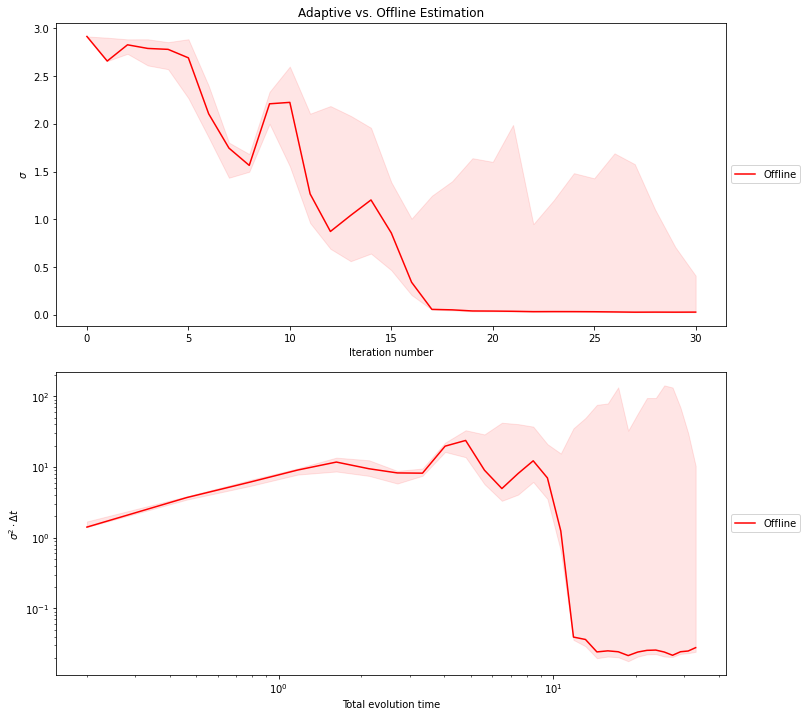

In [ ]:
# -*- coding: utf-8 -*-
"""
Hamiltonian learning implementation for a simple precession example, using both
offline and adaptive Bayesian inference.
The qubit is assumed to be initialized at state |+> for each iteration, and to
evolve under H = f*sigma_z/2, where f is the parameter to be estimated.
A sequential Monte Carlo approximation is used to represent the probability 
distributions, using Hamiltonian Monte Carlo and Metropolis-Hastings mutation 
steps when some threshold effective sample size is crossed.
The evolution of the standard deviations the "precisions" (the variance times 
the cumulative evolution time) with the steps are plotted, and the final values 
of these quantities (in addition to the actual error) are printed.
The algorithm is repeated for a number of runs with randomly picked real
values, and medians are taken over all of them to get the results and graphs.
"""

import sys, random, copy, pickle, matplotlib.pyplot as plt
from autograd import grad, numpy as np
np.seterr(all='warn')

dim=1
total_HMC, accepted_HMC = 0, 0
total_MH, accepted_MH = 0, 0

N_particles = 100 # Number of samples used to represent the probability
#distribution, using a sequential Monte Carlo approximation.

f_real = 0 # The actual precession frequency we mean to estimate 
#(will be picked at random for each run).

fmin, fmax = 0, 10 

def measure(t, real_data = False):
    '''
    Simulates the measurement of the quantum system of the x component of spin 
    at a given time t after initialization at state |+>.
    
    Parameters
    ----------
    t: float
        The evolution time between the initialization and the projection.
    alpha: int, optional
        The exponential decay parameter (Default is 0).
    tries: int, optional
        The amount of times the measurement is repeated (Default is 1).
        
    Returns
    -------
    1 if the result is |+>, 0 if it is |->.
    '''
    if real_data:
      return measure_IBMQ(t)
    else:
      r = random.random()
      p = np.cos(2*np.pi*f_real*t/2)**2
      if (r<p):
          return 1
      return 0

def simulate_1(test_f, t):
    '''
    Provides an estimate for the likelihood  P(D=1|test_f,t) of an x-spin 
    measurement at time t yielding result |+>, given a test parameter for the 
    fixed form Hamiltonian. 
    
    Parameters
    ----------
    test_f: float
        The test precession frequency.
    t: float
        The evolution time between the initialization and the projection.
        
    Returns
    -------
    p1: float
        The estimated probability of finding the particle at state |+>.
    '''
    p1 = np.cos(2*np.pi*test_f*t/2)**2
    return p1

def likelihood(data, test_f):
    '''
    Provides an estimate for the likelihood  P(D|test_f,t) of an x-spin 
    measurement at time t yielding a given result, given a test parameter for  
    the fixed form Hamiltonian. 
    
    Parameters
    ----------
    data: [(float,int)]
        A vector of experimental results and controls, each datum being of the 
        form (time,outcome), where 'time' is the control used for each 
        experiment and 'outcome' is its result.
    test_f: float
        The test precession frequency.
        
    Returns
    -------
    p: float
        The estimated probability of obtaining the input outcome. 
    '''
    if np.size(data)==2:
        t,outcome = data if len(data)==2 else data[0] # May be wrapped in array.
        p = simulate_1(test_f,t)*(outcome==1)+\
            (1-simulate_1(test_f,t))*(outcome==0) 
    else:
        p = np.product([likelihood(datum, test_f) for datum in data])
    return p 

def loglikelihood(data, test_f):
    '''
    Provides an estimate for the likelihood  P(D|test_f,t) of an x-spin 
    measurement at time t yielding a given result, given a test parameter for  
    the fixed form Hamiltonian. 
    
    Parameters
    ----------
    data: [(float,int)]
        A vector of experimental results and controls, each datum being of the 
        form (time,outcome), where 'time' is the control used for each 
        experiment and 'outcome' is its result.
    test_f: float
        The test precession frequency.
        
    Returns
    -------
    p: float
        The estimated probability of obtaining the input outcome. 
    '''
    p = np.sum([np.log(likelihood(datum, test_f)) for datum in data])
    return p 

def U_gradient(data,test_f,autograd=False):
    '''
    Evaluates the derivative of the target "energy" associated to the likelihood 
    at a time t seen as a probability density, given a frequency for the fixed 
    form Hamiltonian. 
    
    Parameters
    ----------
    data: [(float,int)]
        A vector of experimental results and controls, each datum being of the 
        form (time,outcome), where 'time' is the control used for each 
        experiment and 'outcome' is its result.
    test_f: float
        The frequency to be used for the likelihood.
    autograd: bool, optional
        Whether to use automatic differenciation (Default is False).
        
    Returns
    -------
    DU: float
        The derivative of the "energy".
    '''
    
    '''
    The cosine must be different from 0 if the outcome is 1, and from -1/1 if 
    the outcome is 0 (so that the divisor is non-zero when evaluating the            
    derivative).
    '''
    usable_data = [(t,outcome) for (t,outcome) in data 
            if (np.cos(test_f*t/2)!=1 or outcome!=1)
            and (abs(np.cos(test_f*t/2))!=1 or outcome!=0)]
    
    if autograd: 
        minus_DU_f = grad(loglikelihood,1)
        DU = -minus_DU_f(usable_data,float(test_f))
    else:
        DU = 0
        for (t,outcome) in usable_data:
            if outcome==1:
                DU+=t*np.sin(test_f*t/2)/np.cos(test_f*t/2)
            if outcome==0:
                DU-=t*np.sin(test_f*t/2)*np.cos(test_f*t/2)/\
                np.sin(test_f*t/2)**2
    return(DU)

def gaussian(x, mu, sigma, normalize=False):
    '''
    Evaluates a gaussian function at a given point for some specified set of
    parameters.
    
    Parameters
    ----------
    x: float
        The point at which the function is to be evaluated.
    mu: float
        The mean to be used for the gaussian function.
    sigma: float
        The standard deviation to be used for the gaussian function.
    normalize: bool, optional
        Whether to normalize the result (Default is False).
        
    Returns
    -------
    e: float
        The value of the gaussian function at the provided point.
    '''
    power = -(x-mu)**2/(2*sigma**2)
    if not normalize:
        e = np.exp(power)
        return e
    else:
        norm = (2*np.pi*sigma**2)**0.5  
        e = e/norm
        return e

first_metropolis_hastings_step = True
def metropolis_hastings_step(data, particle, s=1, factor=0.1,
                             left_constraint = fmin,right_constraint=fmax): 
    '''
    Performs a Metropolis-Hastings mutation on a given particle, using a 
    gaussian function for the proposals.
    
    Parameters
    ----------
    data: [(float,int)]
        A vector of experimental results obtained so far and their respective 
        controls, each datum being of the form (time,outcome), where 'time' is          
        the control used for each experiment and 'outcome' is its result.
    particle: float
        The particle to undergo a mutation step.
    s: float, optional
        The standard deviation to be multiplied by a factor and then used as 
        standard deviation for the normal distribution used for the proposal 
        (Default is 1).
    factor: float, optional
        The factor 's' should be be multiplied by to get the standard deviation
        of the the normal distribution used for the proposal (Default is 0.05).
    left_constraint: float
        The leftmost bounds to be enforced for the particle's motion.
    right_constraint: float
        The rightmost bounds to be enforced for the particle's motion.
        
    Returns
    -------
    particle: float
        The mutated particle.
    p: float
        The acceptance probability to be used for the evolved particle as a 
        Monte Carlo proposal.
    '''
    global first_metropolis_hastings_step
    if first_metropolis_hastings_step:
      if (s!=1):
          sigma = "sigma"
      else:
          cov = "1"
      print("MH:  s=%s, factor=%.4f" % (sigma,factor))
      first_metropolis_hastings_step = False

    sigma = s**0.5*factor # Numpy normal uses stdev, not variance.

    # Start with any invalid value.
    new_particle = left_constraint-1
    
    # Get a proposal that satisfies the constraints.
    while (new_particle < left_constraint or new_particle > right_constraint):
        new_particle = np.random.normal(particle, sigma)
        
    # Compute the probabilities of transition for the acceptance probability.
    p = likelihood(data,new_particle)*gaussian(particle,new_particle,
                                                    sigma)/ \
        (likelihood(data,particle)*gaussian(new_particle,particle,sigma))
    return new_particle,p

def simulate_dynamics(data, initial_momentum, initial_particle, m, L, eta,
                      left_constraint = 0, right_constraint=10):    
    '''
    Simulates Hamiltonian dynamics for a given particle, using leapfrog 
    integration.
    
    Parameters
    ----------
    data: [(float,int)]
        A vector of experimental results obtained so far and their respective 
        controls, each datum being of the form (time,outcome), where 'time' is          
        the control used for each experiment and 'outcome' is its result.
    initial_momentum: float
        The starting momentum vector. 
    initial_particle: float
        The particle for which the Hamiltonian dynamics is to be simulated.
    m: float
        The mass to be used when simulating the Hamiltonian dynamics (a HMC 
        tuning parameter).
    L: int
        The amount of integration steps to be used when simulating the 
        Hamiltonian dynamics (a HMC tuning parameter).
    eta: float
        The integration stepsize to be used when simulating the Hamiltonian 
        dynamics (a HMC tuning parameter).
    left_constraints: float
        The leftmost bound to be enforced for the particle's motion.
    right_constraints: float
        The rightmost bound to be enforced for the particle's motion.
        
    Returns
    -------
    particle: float
        The particle having undergone motion.
    p: float
        The acceptance probability to be used for the evolved particle as a 
        Monte Carlo proposal.
    '''    
    new_particle = initial_particle
    DU = U_gradient(data,new_particle)
    global f_real
    
    # Perform leapfrog integration according to Hamilton's equations.
    new_momentum = initial_momentum - 0.5*eta*DU
    for l in range(L):
        new_particle = new_particle + eta*new_momentum/m
        
        # Enforce the constraint that both the frequency lie within the prior 
        #distribution. 
        # Should a limit be crossed, the position and momentum are chosen such 
        #that the particle "rebounds".
        if (new_particle < left_constraint):
            new_particle = left_constraint+(left_constraint-new_particle)
            new_momentum = -new_momentum
        if (new_particle > right_constraint): # Use the upper limit from the 
        #prior.
            new_particle = right_constraint-(new_particle-right_constraint)
            new_momentum = -new_momentum
        DU = U_gradient(data,new_particle)
        if (l != L-1):
            new_particle = new_particle - eta*DU
    new_momentum = new_momentum - 0.5*eta*DU


    p = np.exp(-loglikelihood(data,initial_particle)-\
               (-loglikelihood(data,new_particle))+\
                   initial_momentum**2/(2*m)-new_momentum**2/(2*m))
    
    '''
    if (p<0.1):
        sys.exit('p too small')
    '''
    
    return new_particle, p
        
first = True
def hamiltonian_MC_step(data, point, m=1, L=20, eta=10**-4, 
                        threshold=1):
    '''
    Performs a Hamiltonian Monte Carlo mutation on a given particle.
    
    Parameters
    ----------
    data: [(float,int)]
        A vector of experimental results obtained so far and their respective 
        controls, each datum being of the form (time,outcome), where 'time' is          
        the control used for each experiment and 'outcome' is its result.
    t: float
        The time at which the current iteration's measurement was performed.
        This is relevant because the target function and its derivative are 
        time-dependent.
    particle: float
        The frequency particle to undergo a mutation step.
    m: float, optional
        The mass to be used when simulating the Hamiltonian dynamics (a HMC 
        tuning parameter) (Default is 1).
    L: int, optional
        The amount of integration steps to be used when simulating the 
        Hamiltonian dynamics (a HMC tuning parameter) (Default is 20).
    eta: float, optional
        The integration stepsize to be used when simulating the Hamiltonian 
        dynamics (a HMC tuning parameter) (Default is exp(-4)).
    threshold: float, optional
        The highest HMC acceptance rate that should trigger a Metropolis-
        -Hastings mutation step (as an alternative to a  HMC mutation step) 
        (Default is 0.1). 
        
    Returns
    -------
    particle: float
        The mutated frequency particle.
    '''
    if (threshold<1):
        print("The HMC implementation is outdated and there's a factor of"
        " 2*np.pi missing in the gradients (so f would be angular freq), fix it")
        # Perform a Hamiltonian Monte Carlo mutation.
        global first
        if first:
            if (m!=1):
                mass = "cov"
            else:
                mass = "1"
            print("HMC: m=%s, L=%d, eta=%f" % (mass,L,eta))
            first = False
            
        global total_HMC, accepted_HMC, total_MH, accepted_MH
        initial_momentum = np.random.normal(0, scale=m)
        new_point, p = simulate_dynamics(data,initial_momentum,point,
                                         m,L,eta)
    else:
        p = 0
        
    # If the Hamiltonian Monte Carlo acceptance probability is too low,
    #a Metropolis-Hastings mutation will be performed instead.
    # This is meant to saufegard the termination of the program if the leapfrog
    #integration is too inaccurate for a given set of parameters and experiment
    #controls (which tends to happen close to or at the assymptotes of the log-
    #-likelihood).
    
    if (p < threshold):
        MH = True
        new_point, p = metropolis_hastings_step(data,point,s=1/m)
        total_MH += 1
    else:
        MH = False
        total_HMC += 1
        
    a = min(1,p)
    if (np.random.rand() < a):
        if MH:
            accepted_MH += 1
        else:
            accepted_HMC += 1
        return(new_point)
    else:
        return(point)

def bayes_update(data, distribution, threshold=N_particles/2):
    '''
    Updates a prior distribution according to the outcome of a measurement, 
    using Bayes' rule. 
    
    Parameters
    ----------
    data: [(float,int)]
        A vector of experimental results obtained so far and their respective 
        controls, each datum being of the form (time,outcome), where 'time' is          
        the control used for each experiment and 'outcome' is its result.
    distribution: dict
        , with (key,value):=(frequency particle,importance weight)
        The prior distribution (SMC approximation). When returning, it will 
        have been updated according to the provided experimental datum.
    threshold: float, optional
        The threshold effective sample size that should trigger a resampling 
        step (Default is N_particles/2). 
        
    t: float
        The time at which the measurement was performed, which characterizes 
        it. The reference (t=0) is taken as the time of initialization.
    '''
    global N_particles
    acc_weight = 0
    acc_squared_weight = 0
    
    # Update weights based on last likelihood obtained (as in SMC). 
    for particle in distribution:
        new_weight = likelihood(data[-1],particle)*distribution[particle]
        distribution[particle] = new_weight
        acc_weight += new_weight
    
    # Normalize the weights.
    for particle in distribution:
        w = distribution[particle]/acc_weight
        distribution[particle] = w
        acc_squared_weight += w**2 # The inverse participation ratio will be
        #used to decide whether to resample.

    if (1/acc_squared_weight <= threshold):
        selected_particles = random.choices(list(distribution.keys()), 
                                              weights=distribution.values(),
                                              k=N_particles)
        distribution.clear()
      
        cov = SMCparameters(selected_particles,list=True)[1]**2
        # The covariance will be used as a mass, so it must be positive.
        if (cov==0):
            return
        
        for particle in selected_particles:
            new_particle = hamiltonian_MC_step(data, particle, m=1/cov)
            if new_particle not in distribution:
                distribution[new_particle] = 1/N_particles
            else:
                distribution[new_particle] += 1/N_particles
    return(distribution)

def SMCparameters(distribution, stdev=True, list=False):
    '''
    Calculates the mean and (optionally) standard deviation of a given 
    distribution.
    
    Parameters
    ----------
    distribution: dict
        , with (key,value):=(frequency particle,importance weight)
        The distribution (SMC approximation) whose parameters are to be 
        calculated.
    stdev: bool
        To be set to False if the standard deviation is not to be returned 
        (Default is True).
        
    Returns
    -------
    mean: float
        The mean of the distribution.
    stdev: float
        The standard deviation of the distribution.
    '''
    mean = 0
    meansquare = 0
    for particle in distribution:
        f = particle
        if list: # Distribution is given as a dictionary with implicitly 
        #uniform weights.
            w = 1/len(distribution)
        else: # Distribution is given by a dictionary with values as weights.
            w = distribution[particle]
        mean += f*w
        meansquare += f**2*w
    if not stdev:
        return mean
    stdev = abs(mean**2-meansquare)**0.5
    return mean,stdev

def offline_estimation(distribution, data):
    '''
    Estimates the precession frequency by defining a set of experiments, 
    performing them, and updating a given prior distribution according to their 
    outcomes (using Bayesian inference).
    
    Parameters
    ----------
    distribution: dict
        , with (key,value):=(frequency particle,importance weight)
        The prior distribution (SMC approximation).
    steps: int
        The total number of experiments to be performed.
        
    Returns
    -------
    mean: float
        The mean of the final distribution.
    stdev: float
        The standard deviation of the final distribution.
    means: [float]
        A list of the consecutive distribution means, including the prior's and
        the ones resulting from every intermediate step.
    stdevs: [float]
        A list of the consecutive distribution standard deviations, including 
        the prior's and the ones resulting from every intermediate step.
    '''
    mean, stdev = SMCparameters(distribution)
    means, stdevs = [], []
    means.append(mean)
    stdevs.append(stdev) 

    for i in range(len(data)):
        # Update the distribution: get the posterior of the current iteration, 
        #which is the prior for the next.
        distribution = bayes_update(data[:(i+1)],distribution) 
        
        mean,stdev = SMCparameters(distribution)
        means.append(mean)
        stdevs.append(stdev) 
    ts = [0] + [datum[0] for datum in data]
    cumulative_times = np.cumsum(ts)
        
    return distribution, (means, stdevs, cumulative_times)
    
def expected_utility(distribution, time):
    '''
    Returns the expectation value for the utility of a measurement time.
    The utility function considered is a weighed sum of the negative variances
    of the two parameters, adjusted for their relative scale.
    Its expectation value is computed over all outcomes, given the current
    distribution.
    
    Parameters
    ----------
    distribution: dict
        , with (key,value):=(particle,importance weight) 
        The prior distribution (SMC approximation).
    time: float
        The measurement time for which the utility is to be computed.
        
    Returns
    -------
    utility: float
        The expectation value for the utility of the provided measurement time. 
    '''
    # Obtain the probability of each oucome, given the current distribution.
    p1=0
    for particle in distribution:
        weight = distribution[particle]
        p1 += likelihood((time,1),particle)*weight
    p0 = 1-p1
        
    dist_0 = copy.deepcopy(distribution)
    dist_1 = copy.deepcopy(distribution)
    
    # Update the distribution assuming each of the possible outcomes (no 
    #resampling).
    dist_0 = bayes_update([(time,0)],dist_0, threshold=0) 
    dist_1 = bayes_update([(time,1)],dist_1, threshold=0)
    
    # Compute the expected utility for each oucome.
    stdev_0 = SMCparameters(dist_0)[1]
    stdev_1 = SMCparameters(dist_1)[1]
    
    # Calculate the expected utility over all (both) outcomes.
    utility = p0*stdev_0 + p1*stdev_1
    
    return(utility)

first_adaptive_guess = True
def adaptive_guess(distribution, k, guesses, stdev, gaussian = True, 
                   spread = 0.25):
    '''
    Provides a guess for the evolution time to be used for a measurement,
    picked using the PGH, a particle guess heuristic (where the times are 
    chosen to be inverse to the distance between two particles sampled at 
    random from the distribution).
    
    Parameters
    ----------
    distribution: dict
        , with (key,value):=(particle,importance weight) 
        The prior distribution (SMC approximation).
    k: float
        The proportionality constant to be used for the particle guess 
        heuristic.
    guesses: int
        The amount of hypothesis to be picked for the time using the PGH; only 
        the one which maximizes the expected utility among this set will be  
        chosen.
        
    Returns
    -------
    adaptive_t: float
        The measurement time to be used.
    '''
    global first_adaptive_guess
    if first_adaptive_guess:
        strategy = ("normal pick N(1/σ_curr,(1/σ_curr)*%.2f)" % spread) if gaussian else \
                            "distance between 2 randomly picked particles"
        print("Utility maximization: %d guesses (using %s for variability)" 
              " [adaptive_guess]" % 
              (guesses,strategy))
        first_adaptive_guess = False

    adaptive_ts, utilities = [], []
    for i in range(guesses):
        delta=0
        if gaussian:
          if stdev==0:
              print("> σ=0, can't divide to get the time! [adaptive_guess]")
          mean = k/stdev
          time = -1
          while(time < 0):
              time = np.random.normal(mean,scale = mean*spread)
        else:
          while (delta==0):
            [f1, f2] = random.choices(list(distribution.keys()), 
                                      weights=distribution.values(), k=2)
            delta = abs(f1-f2)
          time = k/delta

        if (guesses==1):
            return(time)
        adaptive_ts.append(time)

    for t in adaptive_ts:
        utilities.append(expected_utility(distribution,t))

    chosen_t = adaptive_ts[np.argmin(utilities)]
    return(chosen_t)

first_adaptive_estimation = True
def adaptive_estimation(distribution, steps, run, k=1, guesses=20, precision=0, 
                        real_data = False):
    '''
    Estimates the precession frequency by adaptively performing a set of 
    experiments, using the outcome of each to update the prior distribution 
    (using Bayesian inference) as well as to decide the next experiment to be 
    performed.
    
    Parameters
    ----------
    distribution: dict
        , with (key,value):=(frequency particle,importance weight)
        The prior distribution (SMC approximation).
    steps: int
        The maximum number of experiments to be performed.
    k: float, optional
        The proportionality constant to be used for the particle guess 
        heuristic (Default is 1.25).
    guesses: int, optional
        The amount of hypothesis to be picked for the time; only the one which      
        maximizes the expected utility among this set will be chosen (Default 
        is 1).
        If this quantity is greater than one, the times will be chosen to be 
        inversely proportional to the distance between two particles picked at
        random from the current distribution (instead of to its standard 
        deviation), in order to introduce variability.
    precision: float, optional
        The threshold precision required to stop the learning process before  
        attaining the step number limit (Default is 0).
        
        
    Returns
    -------
    mean: float
        The mean of the final distribution.
    stdev: float
        The standard deviation of the final distribution.
    means: [float]
        A list of the consecutive distribution means, including the prior's and
        the ones resulting from every intermediate step.
    stdevs: [float]
        A list of the consecutive distribution standard deviations, including 
        the prior's and the ones resulting from every intermediate step.
    '''
    global first_adaptive_estimation
    if first_adaptive_estimation is True:
        data_source = ("" if real_data else "not ") + "using real data"
        print("Adaptive estimation: k=%.2f; %d guess(es) per step; %s" % 
              (k,guesses,data_source))
        first_adaptive_estimation = False

    mean, stdev = SMCparameters(distribution)
    means, stdevs, adaptive_ts = [], [], []
    means.append(mean)
    stdevs.append(stdev)
    adaptive_ts.append(0)
    data = []
    
    if (guesses==1):
        adaptive_t = k/stdev
    else:
        adaptive_t = adaptive_guess(distribution, k, guesses, stdev)
        
    adaptive_ts.append(adaptive_t)
        
    for i in range(1,steps+1):
        data.append((adaptive_t, measure(adaptive_t,real_data = real_data)))
        # Update the distribution: get the posterior of the current iteration, 
        #which is the prior for the next.
        if real_data:
            print("> Step %d (run %d). [adaptive_estimation]" % (i,run))

        distribution = bayes_update(data,distribution)
        
        mean,stdev = SMCparameters(distribution)
        means.append(mean)
        stdevs.append(stdev) 
        if (stdev <= precision): 
            break
            
        if (guesses==1):
            adaptive_t = k/stdev
        else:
            adaptive_t = adaptive_guess(distribution, k, guesses, stdev)
        adaptive_ts.append(adaptive_t)
    
    cumulative_times = np.cumsum(adaptive_ts)
    return distribution, (means, stdevs, cumulative_times)

def print_resampler_stats(runs,steps):
    global total_HMC, accepted_HMC, total_MH, accepted_MH
    resampler_calls = (total_HMC + total_MH)/N_particles
    if runs!=0 and steps!=0:
        print("* Average number of resampler calls: %d (%d%%)." 
              % (resampler_calls/runs,round(100*resampler_calls/(runs*steps))))
    else:
        print("Steps = %d, runs = %d, so no resampler calls." % (steps,runs))
    if (total_HMC != 0) or (total_MH != 0):
      print("* Percentage of HMC steps:  %.1f%%." 
            % (100*total_HMC/(total_HMC+total_MH)))
    if (total_HMC != 0):
        print("* Hamiltonian Monte Carlo: %d%% mean particle acceptance rate." 
              % round(100*accepted_HMC/total_HMC))
    if (total_MH != 0):
        print("* Metropolis-Hastings:     %d%% mean particle acceptance rate." 
              % round(100*accepted_MH/total_MH))
    total_HMC, accepted_HMC, total_MH, accepted_MH = 0, 0, 0, 0

def get_data(upload=False, filename=None, every=1, steps=75, rep=1, rev=False,
             tmin=0.02, tmax=3.5, rand=False, print_info=True):
    '''
    Provides a data vector for the inference, either by loading it from a file 
    or by generating it.
    
    Parameters
    ----------
    upload: bool, optional
        Whether to load the data stored in a file (Default is False).
    filename: str, optional
        The name of the file from where the data should be loaded if 'upload' is
        True (Default is None).
    steps: int, optional
        The number of measurements to perform if upload is False (Default is 
        75).
    tmax: float, optional
        The maximum evolution time to be used if upload is False (Default is 
        3.5).
    rand: bool, optional
        Whether to choose the evolution times at random from [0,tmax[ if upload 
        is False (Default us False, the times will be spaced evenly instead).
        
    Returns
    -------
    data: [(float,int)]
        A vector of (evolution time, outcome) tuples.
    '''
    if upload:
        print("> Uploading data from file \'%s\'..." % filename)
        with open(filename, 'rb') as filehandle: 
            data = pickle.load(filehandle)
            # Overwrite step number and maximum time.
            steps, tmax = len(data), max([t for t,outcome in data])
            # Flip the outcomes because the code is structured oppositely to
            #the IBM experiments.
            data = [(t,outcome^1) for t,outcome in data]
            data = data[::every]
            if rev:
                data = data[::-1]
            steps, tmin, tmax = len(data), min([t for t,outcome in data]), \
                max([t for t,outcome in data])
    else:
        if rand:
            ts = [random.uniform(tmin,tmax) for i in range(steps)]
        else:
            ts = np.linspace(tmin,tmax,steps)
            ts = np.repeat(ts,rep)
        if print_info:
            print(("> Using randomly generated " if rand else 
                  "> Using evenly spaced ordered ") + "times.")
        data = [(t,measure(t)) for t in ts]
        if rev:
          data = data[::-1]
    print("Data vector:", data)
    if print_info:
        print("> t∈[%.1f,%.1f[; steps = %d; f∈[%.1f,%.1f[" 
              % (tmin,tmax,steps,fmin,fmax))
    return data,steps

def show_results(off_runs, off_errors, off_mses, steps, runs, axs, label, color,
                 precision = False):
    '''
    The indexes in adapt_runs/off_runs are, by order: 
        - Run number;
        - Desired quantity (0 for mean, 1 for stdev, 2 for cumulative_time)
        - Step number
    '''

    off_stdevs = [np.percentile([s[i] for m,s,t in off_runs],
                                  50,interpolation='nearest') \
                   for i in range(steps+1)]
        
    final_off_stdevs = [s[steps] for m,s,t in off_runs]
    median_final_off_stdevs_index = final_off_stdevs.index(off_stdevs[steps])
    off_error = off_errors[median_final_off_stdevs_index]
    off_mse = np.median(off_mses)
        
    off_times = [np.median([t[i] for m,s,t in off_runs]) \
                   for i in range(steps+1)]
    off_precisions_all = [([s[i]**2*t[i] for i in range(steps+1)]) \
                   for m,s,t in off_runs]
    off_precisions = [np.median([off_precisions_all[i][j] \
                      for i in range(runs)]) for j in range(steps+1)]
    
    off_stdevs_q1s = [np.percentile([s[i] for m,s,t in off_runs], 25) \
                        for i in range(steps+1)]
    off_stdevs_q3s = [np.percentile([s[i] for m,s,t in off_runs], 75) \
                        for i in range(steps+1)]
    off_precisions_q1s = [np.percentile([off_precisions_all[i][j] \
                                           for i in range(runs)], 25) \
                            for j in range(steps+1)]
    off_precisions_q3s = [np.percentile([off_precisions_all[i][j] \
                                           for i in range(runs)], 75) \
                            for j in range(steps+1)]
    
    print("%s:\n- Variance: %.6f\n"
               "- MSE:      %.6f (deviation %.4f)\n"\
          "- Final precision: %.4f" 
          % (label,
            off_stdevs[steps]**2, 
            off_mse,
            off_error,
            off_precisions[steps]))
    
    print("(particles=%d; steps=%d; fmax=%d; runs=%d; 1d, SMC)" 
          % (N_particles,steps,fmax,runs))
    
    x1 = np.array([i for i in range(steps+1)])
    y1 = np.array([off_stdevs[i] for i in range(steps+1)])
    axs[0][0].plot(x1, y1, color=color, label=label)
    q11 = np.array([off_stdevs_q1s[i] for i in range(steps+1)])
    q31 = np.array([off_stdevs_q3s[i] for i in range(steps+1)])
    axs[0][0].fill_between(x1,q11,q31,alpha=0.1,color=color)

    if precision:
        x2 = np.array([off_times[i] for i in range(1,steps+1)])
        y2 = np.array([off_precisions[i] for i in range(1,steps+1)])
        q12 = np.array([off_precisions_q1s[i] for i in range(1,steps+1)])
        q32 = np.array([off_precisions_q3s[i] for i in range(1,steps+1)])
        axs[1][0].loglog(x2, y2,color=color, label=label)
        axs[1][0].fill_between(x2,q12,q32,alpha=0.1,color=color)

def arrange_plots(fig,axs,precision=False):
    axs[0][0].set_ylabel(r'$\sigma$')
    
    axs[0][0].set_title('Adaptive vs. Offline Estimation')
    axs[0][0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[0][0].set_xlabel('Iteration number')

    if precision:
        axs[1][0].set_ylabel(r'$\sigma^2 \cdot \Delta t$')
        axs[1][0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        axs[1][0].set_xlabel('Total evolution time')
    
    fig.subplots_adjust(hspace=0.15)

def meansquarederror(distribution, f_real):
    '''
    Calculates the mean squared error given an SMC distribution.
    
    Parameters
    ----------
    distribution: dict
        , with (key,value):=(particle,importance weight) 
        , and particle=[f,alpha]:=[frequency,decay factor] (as a bit string)
        The distribution (SMC approximation) whose parameters are to be 
        calculated. This can also be a list if the weights are uniform.
    real_parameters: [float]
        The set of real parameters.
        
    Returns
    -------
    r: [float]
        The list of mean squared errors along each dimension (for each 
        parameter).
    '''
    r = 0
    for particle in distribution:
        w = distribution[particle]
        r += (particle-f_real)**2*w
    return r

def run_offline_estimation(runs, steps, fs, prior, datasets=None):
    global f_real
    print("> Running offline estimation.")
    print("|0%",end="|"); progress_interval = 100/runs; counter = 0
    off_runs, off_errors, off_mses = [], [], []
    means, stds = [], []
    for i in range(runs):
        f_real = fs[i] if np.size(fs)>1 else fs[0]
        # if datasets is None:
        #   data,steps = get_data(filename=filename, every=1, upload=True, 
        #                       steps=steps, rep=1, rev=False, tmin=0.2, tmax=tmax, 
        #                       rand=False, print_info=(True if i==0 else False))
        data = datasets[i]

        final_dist, off_run = offline_estimation(copy.deepcopy(prior),data)

        final_mean, final_std = SMCparameters(final_dist)
        means.append(final_mean); stds.append(final_std)

        off_runs.append(off_run)
        off_errors.append(abs(off_runs[i][0][steps-1]-f_real))
        off_mses.append(meansquarederror(final_dist, f_real))
        
        if runs < 10:
            counter+=progress_interval
            print(round(counter),"%",sep="",end="|")
        elif (i%(runs/10)<1): 
            counter+=10
            print(counter,"%",sep="",end="|")

    print("\n-----")
    print("Offline results (%d steps, median over %d runs):" % (steps,runs))
    print("- f = %.6f ± %.6f" % (np.median(means),np.median(stds))) 
    print("-----")
    print_resampler_stats(runs,steps)
    return off_runs, off_errors, off_mses, np.median(stds)

def run_adaptive_estimation(runs, steps, fs, prior, real_data):
    global f_real
    print("> Running adaptive estimation.")
    print("|0%",end="|"); progress_interval = 100/runs; counter = 0
    adapt_runs, adapt_errors, adapt_mses = [], [], []
    means, stds = [], []

    i = 0
    while i != runs:
        f_real = fs[i] if np.size(fs)>1 else fs[0]
        try:
          final_dist, adapt_run = adaptive_estimation(copy.deepcopy(prior),
                                                      steps,
                                                      i,
                                                      real_data=real_data)
        except KeyboardInterrupt as err:
            print("> Keyboard interrupt, breaking from cycle... [run_adaptive_estimation]")
            break
        except SystemExit as err:
            print("> System exit [run_adaptive_estimation] ")
            print(err)
            break
        except Exception as err:
            print("> Error at run number %d [run_adaptive_estimation]." % i)
            print(err)
            continue

        final_mean, final_std = SMCparameters(final_dist)
        means.append(final_mean); stds.append(final_std)

        adapt_runs.append(adapt_run)
        adapt_errors.append(abs(adapt_runs[i][0][steps-1]-f_real))
        adapt_mses.append(meansquarederror(final_dist, f_real))

        i += 1
        if runs < 10:
            counter+=progress_interval
            print(round(counter),"%",sep="",end="|")
        elif (i%(runs/10)<1): 
            counter+=10
            print(counter,"%",sep="",end="|")

    print("\n-----")
    print("Adaptive results (%d steps, median over %d runs):" % (steps,runs))
    print("- f = %.6f ± %.6f" % (np.median(means),np.median(stds))) 
    print("-----")
    print_resampler_stats(runs,steps)
    return adapt_runs, adapt_errors, adapt_mses, steps

def run_adaptive_single(steps, fs, prior, real_data, tol=0):
    global f_real
    print("> Running adaptive estimation (single run).")
    adapt_runs, adapt_errors, adapt_mses = [], [], []
    means, stds = [], []

    f_real = fs[0] 
    final_dist, adapt_run = adaptive_estimation(copy.deepcopy(prior),steps,0,
                                                precision=tol, real_data=real_data)
    final_mean, final_std = SMCparameters(final_dist)
    means.append(final_mean); stds.append(final_std)

    adapt_runs.append(adapt_run)
    adapt_errors.append(abs(adapt_run[0][-1]-f_real))
    adapt_mses.append(meansquarederror(final_dist, f_real))
            
    steps = len(adapt_run[0])-1 # If interrupted due to hitting tolerance level.
    print("-----")
    print("Adaptive results (%d steps, single run):" % steps)
    print("- f = %.6f ± %.6f" % (final_mean,final_std)) 
    print("- Variance = %.6f (deviation %.4f)" % (final_std**2,adapt_errors[-1]))
    print("- MSE    =   %.6f " % adapt_mses[-1])
    print("-----")
    print_resampler_stats(1,steps)
    return adapt_runs, adapt_errors, adapt_mses, steps
    
def generate_dataset_list(ndatasets, steps, tmin, tmax, rep=1):
    datasets = []
    for i in range(ndatasets):
        data,steps = get_data(filename=None, every=1, upload=False, 
                              steps=steps, rep=1, rev=False, tmin=tmin, 
                              tmax=tmax, rand=False)
        datasets.append(data)
    return datasets 

def upload_dataset_list(filename_start, ndatasets, each):
    datasets = []
    for i in range(ndatasets):
        filename = filename_start + str(i) + '.data'
        data,steps = get_data(filename=filename, every=1, upload=True, 
                              steps=75, rep=1, rev=False, tmin=0.2, 
                              tmax=5, rand=False)
        datasets.extend([data for i in range(each)])
    return datasets,steps 

def match_stdev(upload = False):
    global f_real
    f_real = 1.83
    fs = np.linspace(fmin, fmax, N_particles) 
    prior = {}
    for f in fs:
        prior[f] = 1/N_particles # We consider a flat prior up to fmax.
    
    if upload:
      filename_start = 'armonk_echoed_ramsey_data[0.2,2[f=1.83_sched=30_nshots=1_'
      datasets, steps = upload_dataset_list(filename_start, 10, 1)
      runs = len(datasets)
    else: 
      runs = 3
      steps = 30
      datasets = generate_dataset_list(runs, steps, tmin=0.2, tmax=2, rep=1)

    real_fs = [1.83]
    off_runs, off_errors, off_mses, median_std = run_offline_estimation(
                                                            runs, 
                                                            steps,
                                                            real_fs, 
                                                            copy.deepcopy(prior),
                                                            datasets=datasets)
    
    precision = True
    fig, axs = plt.subplots(2 if precision else 1,
                            figsize=(12,12 if precision else 8), 
                            squeeze=False)
    show_results(off_runs, off_errors, off_mses, steps, runs, axs, 
                 'Offline', 'red', precision=precision)

    n_adapt_runs = runs # Will take the run with mean number of steps.
    adapt_runs, adapt_errors, adapt_mses, steps_taken = [], [], [], []
    try:
      for i in range(n_adapt_runs):
          print("> Single run %d [match_stdev]" % i)
          # These will all be single element lists.
          adapt_run, adapt_error, adapt_mse, astep = run_adaptive_single(
                                                                        steps,
                                                                        real_fs,
                                                                        copy.deepcopy(prior),
                                                                        real_data = True,
                                                                        tol = median_std)
          
          # And these lists of length 1 lists except for the steps.
          adapt_runs.append(adapt_run)
          adapt_errors.append(adapt_error)
          adapt_mses.append(adapt_mse)
          steps_taken.append(astep)

          # adapt_runs.extend(adapt_run)
          # adapt_errors.extend(adapt_error)
          # adapt_mses.extend(adapt_mse)
          # steps_taken.append(astep)
    except:
      err = sys.exc_info()[0]
      n_adapt_runs = len(steps_taken)
      print("> Quit at run %d (%s)." % (runs,err))

    # show_results(adapt_runs, adapt_errors, adapt_mses, steps, n_adapt_runs, axs, 
    #              'Adaptive', 'blue', precision=precision, up_to_step=median_steps)

    if n_adapt_runs != 0:
        median_steps = np.percentile(steps_taken,50,interpolation='nearest')
        med_step_index = steps_taken.index(median_steps)
        med_adapt_run, med_adapt_error, med_adapt_mse = (adapt_runs[med_step_index],
                                                        adapt_errors[med_step_index],
                                                        adapt_mses[med_step_index])

        if median_steps<steps:
            print("> Adaptive estimation run took %d steps to match offline estimation's"
            " final variance (median number)." % median_steps)

        show_results(med_adapt_run, med_adapt_error, med_adapt_mse, median_steps,
                    1, axs, 'Adaptive', 'blue', precision=precision)
        
    arrange_plots(fig, axs, precision=precision)

def run_both():
    global f_real
    fs = np.linspace(fmin, fmax, N_particles) 
    prior = {}
    for f in fs:
        prior[f] = 1/N_particles # We consider a flat prior up to fmax.
    real_fs = [1.83]

    real_data = True
    if real_data:
      filename_start = 'armonk_echoed_ramsey_data[0.2,2[f=1.83_sched=15_nshots=1_'
      datasets, steps = upload_dataset_list(filename_start, 100, 1)
      runs = len(datasets)
    else: 
      f_real = real_fs[0]
      runs = 5
      steps = 15
      datasets = generate_dataset_list(runs, steps, tmin=0.2, tmax=2, rep=1)

    
    off_runs, off_errors, off_mses, median_std = run_offline_estimation(
                                                            runs, 
                                                            steps,
                                                            real_fs, 
                                                            copy.deepcopy(prior),
                                                            datasets = datasets)
    adapt_runs, adapt_errors, adapt_mses, asteps = run_adaptive_estimation(
                                                                   runs,
                                                                   steps,
                                                                   real_fs,
                                                                   copy.deepcopy(prior),
                                                                   real_data = real_data)

    precision = True
    fig, axs = plt.subplots(2 if precision else 1,
                            figsize=(12,12 if precision else 8), 
                            squeeze=False)
    show_results(off_runs, off_errors, off_mses, steps, runs, axs, 
                 'Offline', 'red',precision=precision)
    show_results(adapt_runs, adapt_errors, adapt_mses, asteps, runs, axs, 
                 'Adaptive', 'blue',precision=precision)
    arrange_plots(fig, axs,precision=precision)
    print("(n=%d; N=%d; fmax=%d; runs=%d; 1d, SMC)" 
          % (N_particles,steps,fmax,runs))
    plt.savefig('graph.pdf')  
    files.download('graph.pdf')  

run_both()